The dataset was downloaded from Kaggle (https://www.kaggle.com/kanishk307/6000-indian-food-recipes-dataset/notebooks), credit to @kanishk307 (GitHub). 

The dataset was quite clean, but still needed some data cleaning to be done.

In [224]:
import pandas as pd
import numpy as np

raw = pd.read_csv('datasets/IndianFoodDatasetCSV.csv')
df = raw.copy()

columns_to_drop = ['RecipeName', 'Ingredients', 'URL', 'PrepTimeInMins' , 'CookTimeInMins',
                        'TotalTimeInMins','TranslatedInstructions', 'Instructions', 'Servings', 'Srno']

df = df.drop(columns = columns_to_drop).dropna()

# data seems to contain more than just indian cuisines, so I drop these
cuisines_to_drop = ['Mexican', 'Italian Recipes', 'Thai', 'Chinese', 'Asian', 'Middle Eastern', 'European',
                   'Arab', 'Japanese', 'Vietnamese', 'British', 'Greek', 'French', 'Mediterranean', 'Sri Lankan',
                   'Indonesian', 'African', 'Korean', 'American', 'Carribbean', 'World Breakfast', 'Malaysian', 'Dessert',
                   'Afghan', 'Snack', 'Jewish', 'Brunch', 'Lunch']


df = df[~df['Cuisine'].isin(cuisines_to_drop)]
df.shape

(6036, 5)

In [225]:
df.head()

,TranslatedRecipeName,TranslatedIngredients,Cuisine,Course,Diet
0,Masala Karela Recipe,"6 Karela (Bitter Gourd/ Pavakkai) - deseeded,S...",Indian,Side Dish,Diabetic Friendly
1,Spicy Tomato Rice (Recipe),"2-1 / 2 cups rice - cooked, 3 tomatoes, 3 teas...",South Indian Recipes,Main Course,Vegetarian
2,Ragi Semiya Upma Recipe - Ragi Millet Vermicel...,"1-1/2 cups Rice Vermicelli Noodles (Thin),1 On...",South Indian Recipes,South Indian Breakfast,High Protein Vegetarian
3,Gongura Chicken Curry Recipe - Andhra Style Go...,"500 grams Chicken,2 Onion - chopped,1 Tomato -...",Andhra,Lunch,Non Vegeterian
4,Andhra Style Alam Pachadi Recipe - Adrak Chutn...,"1 tablespoon chana dal, 1 tablespoon white ura...",Andhra,South Indian Breakfast,Vegetarian


In [226]:
#dataset contains hindi even in "translated" columns, dropping these for convenience sake
df = df['TranslatedIngredients']

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

#create boolean mask
mask = df.apply(isEnglish)
df = df[mask].dropna()

df.shape #I see we dropped about 700 entries.

(5379,)

In [239]:
#I am interested in only the recipe ingredients
recipes = df

#read file of all indian spices on wikipedia
raw = pd.read_html('https://en.wikipedia.org/wiki/List_of_Indian_spices')
spices = raw[0]['Standard English'].copy().str.lower()

#some important spices I also added from experience/my own cookbook
add = pd.Series(['black mustard seed/raee', 'black salt/kala namak', 'cardamom'])

#some spices are too common (such as pepper) or not a spice, but a vegetable, or are otherwise corrupted (for example,
#cardamom is often listed as "cardamom" nto specifying whether it is black or green)
spices_to_drop = ['black pepper', 'peppercorns', 'capers', 'chili pepper powder', 'cinnamon buds', 
                  'cumin seed ground into balls', 'garlic', 'dried ginger', 'green chili pepper', 'indian bedellium tree',
                 'indian gooseberry', 'mango extract', 'saffron pulp', 'black cumin', 'green cardamom', 'black cardamom']

spices = spices[~spices.isin(spices_to_drop)].append(add)

#editing the spices so that my string counter can find different versions of the same spice
spices = spices.str.replace('amchoor', 'amchur/amchoor') \
                    .replace('asafoetida', 'asafetida/asafoetida/hing') \
                    .replace('alkanet root', 'alkanet/alkanet root') \
                    .replace('capsicum', 'chilli/chili/cayenne') \
                    .replace('celery / radhuni seed', 'celery/radhuni seed') \
                    .replace('bay leaf, indian bay leaf', 'bay leaf/bay leaves/tejpatta') \
                    .replace('curry tree or sweet neem leaf', 'curry leaf/curry leaves/kadi patta') \
                    .replace('fenugreek leaf', 'fenugreek leaf/fenugreek leaves/kasoori methi') \
                    .replace('cumin seed', 'cumin seed/jeera') \
                    .replace('nigella seed', 'nigella seed/black cumin') \
                    .replace('thymol/carom seed', 'fenuthymol/carom seed/ajwain/ajwan') 

### DICTIONARY OF SPICES

In [250]:
# iterate over each recipe and split into individual ingredients

words = []
for recipe in recipes:
    w = recipe.split(',')
    words.append(w)

# iterate over each sublist in list of ingredients and create one list (series), set to lowercase, strip whitespace
    
ing = [item for sublist in words for item in sublist]
ing = pd.Series(ing).str.strip()
ing = ing.str.lower()

# iterate over each row in ingredients, and then over each value in spices, to see if each spice is in the row. 
# Then create dictionary.

dict_of_spices = {key: 0 for key in spices}
for row in ing:
    for k in spices:
        k_new = k.split('/')
        for split in k_new:
            if split in row:
                dict_of_spices[k] += 1

# remove spices that had less than 20 occurences         
                
for key, value in dict_of_spices.copy().items():
    if value < 20:
        del dict_of_spices[key]


### LIST OF SPICES

In [249]:
# do the same as above except output is a list, not a dict

# iterate over each recipe and split into individual ingredients

words = []
for recipe in recipes:
    w = recipe.split(',')
    words.append(w)

# iterate over each sublist in list of ingredients and create one list (series), set to lowercase, strip whitespace
    
ing = [item for sublist in words for item in sublist]
ing = pd.Series(ing).str.strip()
ing = ing.str.lower()

list_of_spices = []
for row in ing:
    for k in spices:
        k_new = k.split('/')
        for split in k_new:
            if split in row:
                k = k.capitalize()
                list_of_spices.append(k)
list_of_spices = pd.Series(list_of_spices)

# change back the spices for better readability and to include indian names where applicable

list_of_spices = list_of_spices.str.replace('Amchur/amchoor','Amchur (dried mango powder)') \
                                   .replace('Bay leaf/bay leaves/tejpatta','Bay leaves') \
                                    .replace('Chilli/chili/cayenne', 'Chilli') \
                                    .replace('Asafetida/asafoetida/hing','Asafetida (hing)') \
                                    .replace('Curry leaf/curry leaves/kadi patta','Curry leaves') \
                                    .replace('Fenuthymol/carom seed/ajwain/ajwan', 'Carom seed (ajwain)') \
                                    .replace('Fenugreek leaf/fenugreek leaves/kasoori methi','Fenugreek leaves (kasoori methi)') \
                                    .replace('Curry leaf/curry leaves/kadi patta','Curry leaves') \
                                    .replace('Cumin seed/jeera','Cumin seed (jeera)') \
                                    .replace('Black salt/kala namak','Black salt (kala namak)') \
                                    .replace('Nigella seed/black cumin','Nigella seed (black cumin)') \
                                    .replace('Celery/radhuni seed','Celery seed (radhuni)') \

# count occurences of each spice
list_of_spices = pd.Series(list_of_spices).value_counts()

# exclude spices that are in less than 20 recipes out of all 5200
list_of_spices = list_of_spices[list_of_spices.values > 20]

# calculate a percentage of in how many recipes is each spice included
list_of_spices = pd.DataFrame(list_of_spices)
list_of_spices.columns = ['freq']
list_of_spices['perc'] = list_of_spices.apply(lambda x: round((x/len(recipes)),2))

#view
list_of_spices

,freq,perc
Chilli,5357,1.00
Cumin seed (jeera),3328,0.62
Turmeric,2199,0.41
Asafetida (hing),1985,0.37
Ginger,1839,0.34
Cloves,1673,0.31
Curry leaves,1260,0.23
Mustard seed,1092,0.20
Cardamom,897,0.17
Coriander powder,863,0.16


### PLOT 

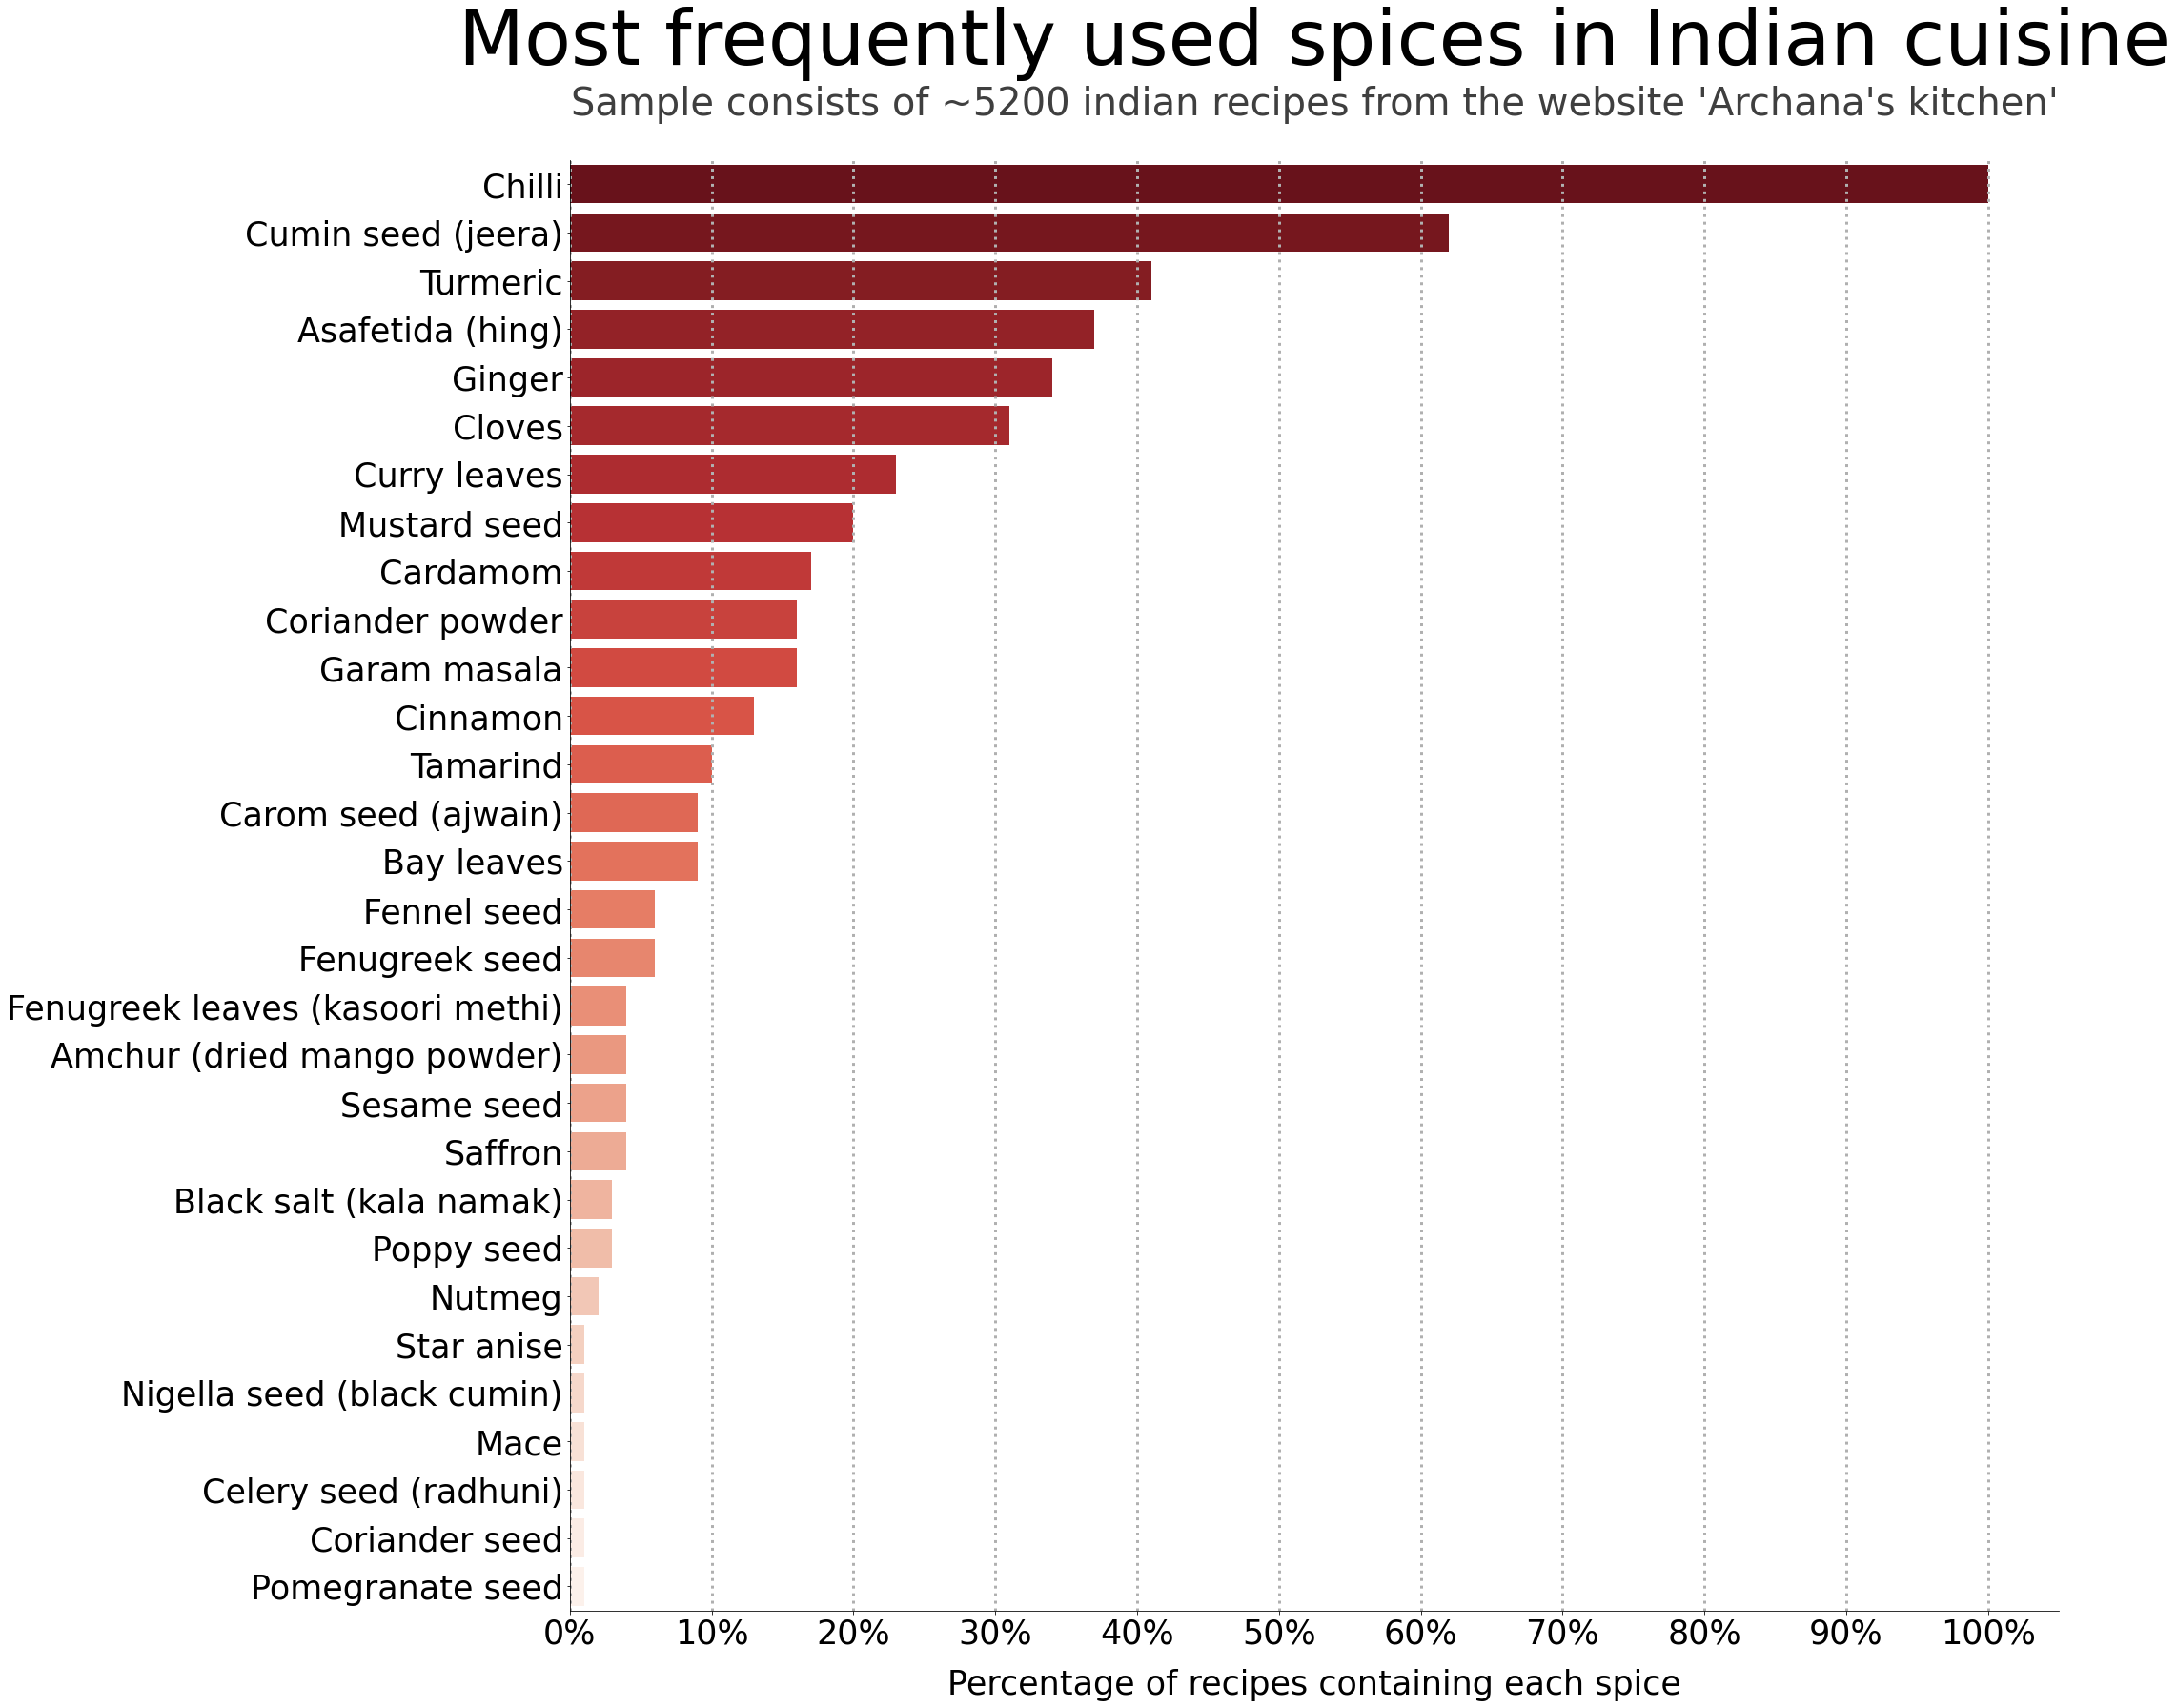

In [223]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

#create fig, axes
fig, ax = plt.subplots(figsize=(28, 28))

#create barplot
sns.barplot(y=list_of_spices.index, x=list_of_spices['perc'], 
            data = list_of_spices, orientation = 'horizontal',  palette="Reds_r")
plt.xticks(fontsize = 35);
plt.yticks(fontsize = 35);
sns.despine()

# titles, labels
ax.set_title('Most frequently used spices in Indian cuisine', fontsize = 80, pad = 100);
ax.text(x=0.5, y=1.025, s="Sample consists of ~5200 indian recipes from the website 'Archana's kitchen'", 
        fontsize=40, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes);
ax.set_xlabel('Percentage of recipes containing each spice', fontsize = 35, labelpad = 20);
ax.set_xticks(np.linspace(0,1,11), minor = False)

# set x axis to percentages
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 

# create grid for better readability
ax.grid(axis = 'x', linestyle = ':', linewidth = 3)